In [1]:
import os
import sys
# import skimage.io
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
# from efficientnet_pytorch import model as enet

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

PANDA 16x128x128 tiles


In [1]:
import os
import cv2
import skimage.io
from tqdm.notebook import tqdm
import zipfile
import numpy as np

In [2]:
# TRAIN = '../input/prostate-cancer-grade-assessment/train_images/' # Replace with path to dataset images
# MASKS = '../input/prostate-cancer-grade-assessment/train_label_masks/' # Replace with path to dataset masks
# TRAIN = "C:\\Users\\Vivian\\Downloads\\panda_train"
TRAIN = "C:\\Users\\Vivian\\Downloads\\panda_train"
MASKS = "C:\\Users\\Vivian\\Downloads\\panda_mask"
# MASKS = "C:\\Users\\Vivian\\Downloads\\panda_mask"
OUT_TRAIN = 'C:\\Users\\Vivian\\Downloads\\train.zip'
OUT_MASKS = 'C:\\Users\\Vivian\\Downloads\\masks.zip'
sz = 128
N = 16 

In [3]:
def tile(img, mask):
    result = []
    shape = img.shape
    pad0,pad1 = (sz - shape[0]%sz)%sz, (sz - shape[1]%sz)%sz
    img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                constant_values=255)
    mask = np.pad(mask,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                constant_values=0)
    img = img.reshape(img.shape[0]//sz,sz,img.shape[1]//sz,sz,3)
    img = img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
    mask = mask.reshape(mask.shape[0]//sz,sz,mask.shape[1]//sz,sz,3)
    mask = mask.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
    if len(img) < N:
        mask = np.pad(mask,[[0,N-len(img)],[0,0],[0,0],[0,0]],constant_values=0)
        img = np.pad(img,[[0,N-len(img)],[0,0],[0,0],[0,0]],constant_values=255)
    idxs = np.argsort(img.reshape(img.shape[0],-1).sum(-1))[:N]
    img = img[idxs]
    mask = mask[idxs]
    for i in range(len(img)):
        result.append({'img':img[i], 'mask':mask[i], 'idx':i})
    return result

In [5]:
x_tot,x2_tot = [],[]
names = [name[:-10] for name in os.listdir(MASKS)]
with zipfile.ZipFile(OUT_TRAIN, 'w') as img_out,\
 zipfile.ZipFile(OUT_MASKS, 'w') as mask_out:
    for name in tqdm(names):
        img = skimage.io.MultiImage(os.path.join(TRAIN,name+'.tiff'))[-1]
        mask = skimage.io.MultiImage(os.path.join(MASKS,name+'_mask.tiff'))[-1]
        tiles = tile(img,mask)
        for t in tiles:
            img,mask,idx = t['img'],t['mask'],t['idx']
            x_tot.append((img/255.0).reshape(-1,3).mean(0))
            x2_tot.append(((img/255.0)**2).reshape(-1,3).mean(0)) 
            #if read with PIL RGB turns into BGR
            img = cv2.imencode('.png',cv2.cvtColor(img, cv2.COLOR_RGB2BGR))[1]
            img_out.writestr(f'{name}_{idx}.png', img)
            mask = cv2.imencode('.png',mask[:,:,0])[1]
            mask_out.writestr(f'{name}_{idx}.png', mask)

  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
#image stats
img_avr =  np.array(x_tot).mean(0)
img_std =  np.sqrt(np.array(x2_tot).mean(0) - img_avr**2)
print('mean:',img_avr, ', std:', np.sqrt(img_std))

mean: [0.60032005 0.29792841 0.60673161] , std: [0.42139806 0.38447853 0.33984335]


PANDA 16x128x128 tiles - no mask

In [60]:
import os
import cv2
import skimage.io
from tqdm.notebook import tqdm
import zipfile
import numpy as np

TRAIN = "C:\\Users\\Vivian\\Downloads\\panda_train"
OUT_TRAIN = 'C:\\Users\\Vivian\\Downloads\\train-nomask.zip'

sz = 128  # Tile size
N = 16    # Number of tiles per image

# Tile function (for image only)
def tile(img):
    result = []
    shape = img.shape
    pad0, pad1 = (sz - shape[0] % sz) % sz, (sz - shape[1] % sz) % sz
    
    # Pad the image with white pixels (255)
    img = np.pad(img, [[pad0 // 2, pad0 - pad0 // 2], [pad1 // 2, pad1 - pad1 // 2], [0, 0]], constant_values=255)
    
    # Reshape and split into tiles
    img = img.reshape(img.shape[0] // sz, sz, img.shape[1] // sz, sz, 3)
    img = img.transpose(0, 2, 1, 3, 4).reshape(-1, sz, sz, 3)
    
    # Ensure we have at least N tiles
    if len(img) < N:
        img = np.pad(img, [[0, N - len(img)], [0, 0], [0, 0], [0, 0]], constant_values=255)
    
    # Select the top N tiles with the most information
    idxs = np.argsort(img.reshape(img.shape[0], -1).sum(-1))[:N]
    img = img[idxs]
    
    # Append tiles to the result
    for i in range(len(img)):
        result.append({'img': img[i], 'idx': i})
    return result

# Main loop to process images
x_tot, x2_tot = [], []
names = [os.path.splitext(name)[0] for name in os.listdir(TRAIN) if name.endswith('.tiff')]

with zipfile.ZipFile(OUT_TRAIN, 'w') as img_out:
    for name in tqdm(names):
        img_path = os.path.join(TRAIN, name + '.tiff')
        
        # Read the image
        img = skimage.io.MultiImage(img_path)[-1]  # Use the highest resolution level

        # Tile the image
        tiles = tile(img)
        for t in tiles:
            img, idx = t['img'], t['idx']
            
            # Compute image statistics
            x_tot.append((img / 255.0).reshape(-1, 3).mean(0))
            x2_tot.append(((img / 255.0) ** 2).reshape(-1, 3).mean(0))
            
            # # Save tiled image
            img = cv2.imencode('.png', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))[1]
            img_out.writestr(f'{name}_{idx}.png', img)

# Compute image stats
img_avr = np.array(x_tot).mean(0)
img_std = np.sqrt(np.array(x2_tot).mean(0) - img_avr**2)
print('mean:', img_avr, ', std:', np.sqrt(img_std))


  0%|          | 0/1 [00:00<?, ?it/s]

Image dtype: uint8
Image min: 0 max: 255 mean: 252.11031091621467
mean: [0.60032005 0.29792841 0.60673161] , std: [0.42139806 0.38447853 0.33984335]


PANDA 16x128x128 tiles - no mask, Breast WSI

In [48]:
import os
import cv2
import skimage.io
from tqdm.notebook import tqdm
import zipfile
import numpy as np
from tifffile import TiffFile

# TRAIN = "C:\\Users\\Vivian\\Downloads\\panda_train"
# OUT_TRAIN = 'C:\\Users\\Vivian\\Downloads\\train-nomask.zip'
TRAIN = "C:\\Users\\Vivian\\Documents\\FA_57B" # test with breast WSI
OUT_TRAIN = 'C:\\Users\\Vivian\\Documents\\FA57B-tiles.zip' # test with breast WSI


sz = 128  # Tile size
N = 16    # Number of tiles per image

# Tile function (for image only)
def tile(img):
    result = []
    shape = img.shape
    pad0, pad1 = (sz - shape[0] % sz) % sz, (sz - shape[1] % sz) % sz
    
    # Pad the image with white pixels (255)
    img = np.pad(img, [[pad0 // 2, pad0 - pad0 // 2], [pad1 // 2, pad1 - pad1 // 2], [0, 0]], constant_values=255)
    
    # Reshape and split into tiles
    img = img.reshape(img.shape[0] // sz, sz, img.shape[1] // sz, sz, 3)
    img = img.transpose(0, 2, 1, 3, 4).reshape(-1, sz, sz, 3)
    
    # Ensure we have at least N tiles
    if len(img) < N:
        img = np.pad(img, [[0, N - len(img)], [0, 0], [0, 0], [0, 0]], constant_values=255)
    
    # Select the top N tiles with the most information
    idxs = np.argsort(img.reshape(img.shape[0], -1).sum(-1))[:N]
    img = img[idxs]
    
    # Append tiles to the result
    for i in range(len(img)):
        result.append({'img': img[i], 'idx': i})
    return result

# Main loop to process images
x_tot, x2_tot = [], []
names = [os.path.splitext(name)[0] for name in os.listdir(TRAIN) if name.endswith('.tif')]

with zipfile.ZipFile(OUT_TRAIN, 'w') as img_out:
    for name in tqdm(names):
        img_path = os.path.join(TRAIN, name + '.tif')
        print(img_path) # debug        
        # Read the image
        img = skimage.io.MultiImage(img_path)[-1]  # Use the highest resolution level
        # with TiffFile(img_path) as tif:
        #     img = tif.pages[-1].asarray()  # Read the highest resolution page # using tifffile instead of skimage
        
        # Tile the image
        tiles = tile(img)
        for t in tiles:
            img, idx = t['img'], t['idx']
            
            # Compute image statistics
            x_tot.append((img / 255.0).reshape(-1, 3).mean(0))
            x2_tot.append(((img / 255.0) ** 2).reshape(-1, 3).mean(0))
            
            # Save tiled image
            img = cv2.imencode('.png', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))[1]
            img_out.writestr(f'{name}_{idx}.png', img)

# Compute image stats
img_avr = np.array(x_tot).mean(0)
img_std = np.sqrt(np.array(x2_tot).mean(0) - img_avr**2)
print('mean:', img_avr, ', std:', np.sqrt(img_std))


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\Vivian\Documents\FA_57B\FA57B-image.tif


RuntimeError: incompatible keyframe

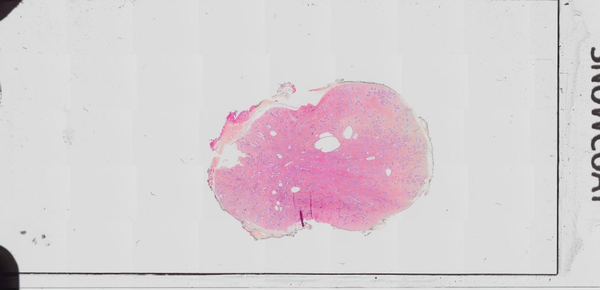

In [27]:
file_path = "C:\\Users\\Vivian\\Documents\\\FA_57B\\FA57B-image.tif"

# Create an OpenSlide object
slide = openslide.OpenSlide(file_path)

max_size=(600,400)
# generate small image thumbnail
display(slide.get_thumbnail(size=max_size))


In [37]:
from tifffile import TiffFile

# Inspect the TIFF file
with TiffFile("C:\\Users\\Vivian\\Documents\\FA_57B\\FA57B-image.tif") as tif:
    print("Pages:", len(tif.pages))
    print("Compression:", tif.pages[0].tags['Compression'].value)


Pages: 8
Compression: COMPRESSION.JPEG


In [41]:
from tifffile import TiffFile

with TiffFile("C:\\Users\\Vivian\\Documents\\FA_57B\\FA57B-image.tif") as tif:
    for i, page in enumerate(tif.pages):
        print(f"Page {i}: Shape = {page.shape}, Compression = {page.tags['Compression'].value}")


Page 0: Shape = (7324, 15164, 3), Compression = 7
Page 1: Shape = (3662, 7582, 3), Compression = 7
Page 2: Shape = (1831, 3791, 3), Compression = 7
Page 3: Shape = (915, 1895, 3), Compression = 7
Page 4: Shape = (457, 947, 3), Compression = 7
Page 5: Shape = (228, 473, 3), Compression = 7
Page 6: Shape = (114, 236, 3), Compression = 7
Page 7: Shape = (57, 118, 3), Compression = 7


In [40]:
from tifffile import TiffFile

# Inspect the TIFF file
with TiffFile("C:\\Users\\Vivian\\Downloads\\panda_train\\0005f7aaab2800f6170c399693a96917.tiff") as tif:
    print("Pages:", len(tif.pages))
    print("Compression:", tif.pages[0].tags['Compression'].value)


Pages: 3
Compression: COMPRESSION.JPEG


In [42]:
from tifffile import TiffFile

with TiffFile("C:\\Users\\Vivian\\Downloads\\panda_train\\0005f7aaab2800f6170c399693a96917.tiff") as tif:
    for i, page in enumerate(tif.pages):
        print(f"Page {i}: Shape = {page.shape}, Compression = {page.tags['Compression'].value}")


Page 0: Shape = (29440, 27648, 3), Compression = 7
Page 1: Shape = (7360, 6912, 3), Compression = 7
Page 2: Shape = (1840, 1728, 3), Compression = 7


In [67]:
import os
import cv2
import numpy as np
import zipfile
from tqdm.notebook import tqdm
from PIL import Image
import openslide

TRAIN = "C:\\Users\\Vivian\\Documents\\FA_57B"
OUT_TRAIN = 'C:\\Users\\Vivian\\Documents\\FA57B-tiles2.zip'
# TRAIN = "C:\\Users\\Vivian\\Downloads\\panda_train" # returns the same mean values when using openslide as it does when using skimage
# OUT_TRAIN = 'C:\\Users\\Vivian\\Downloads\\train-nomask2.zip'


sz = 128  # Tile size
N = 16    # Number of tiles per image

# Tile function (for image only)
def tile(img):
    result = []
    shape = img.shape
    pad0, pad1 = (sz - shape[0] % sz) % sz, (sz - shape[1] % sz) % sz

    # Debug: Print padding information
    print(f"Padding applied: Top-Bottom: {pad0}, Left-Right: {pad1}")

    # Pad the image with white pixels (255)
    img = np.pad(img, [[pad0 // 2, pad0 - pad0 // 2], [pad1 // 2, pad1 - pad1 // 2], [0, 0]], constant_values=255)
    print("After padding - Min:", img.min(), "Max:", img.max(), "Mean:", img.mean())

    # Reshape and split into tiles
    img = img.reshape(img.shape[0] // sz, sz, img.shape[1] // sz, sz, 3)
    img = img.transpose(0, 2, 1, 3, 4).reshape(-1, sz, sz, 3)

    # Inspect all tiles before selection *** debugging
    print("Inspecting all tiles before selection:")
    for i, tile in enumerate(img):
        print(f"Tile {i}: Min = {tile.min()}, Max = {tile.max()}, Mean = {tile.mean()}")
    
    # Ensure we have at least N tiles
    if len(img) < N:
        img = np.pad(img, [[0, N - len(img)], [0, 0], [0, 0], [0, 0]], constant_values=255)
        print("After ensuring minimum tiles - Min:", img.min(), "Max:", img.max(), "Mean:", img.mean())

    # # Select the top N tiles with the most information
    # idxs = np.argsort(img.reshape(img.shape[0], -1).sum(-1))[:N]
    # img = img[idxs]
    # print(f"Selected {len(img)} tiles based on information content")

    # # Select the top N tiles based on contrast (standard deviation) ** trying different selection technique
    # tile_std = img.reshape(img.shape[0], -1).std(-1)
    # idxs = np.argsort(tile_std)[-N:]  # Select tiles with highest contrast
    # img = img[idxs]

    tile_means = img.reshape(img.shape[0], -1).mean(-1)
    idxs = np.argsort(tile_means)[-N:]  # Select tiles with the highest mean
    img = img[idxs]

    # Inspect selected tiles *** debugging
    print("Inspecting selected tiles:")
    for i, tile in enumerate(img):
        print(f"Tile {i}: Min = {tile.min()}, Max = {tile.max()}, Mean = {tile.mean()}")
    

    # Append tiles to the result
    for i in range(len(img)):
        print(f"Tile {i} - Min: {img[i].min()}, Max: {img[i].max()}, Mean: {img[i].mean()}")
        result.append({'img': img[i], 'idx': i})
    return result

# Main loop to process images
x_tot, x2_tot = [], []
names = [os.path.splitext(name)[0] for name in os.listdir(TRAIN) if name.endswith('.tif')]

with zipfile.ZipFile(OUT_TRAIN, 'w') as img_out:
    for name in tqdm(names):
        img_path = os.path.join(TRAIN, name + '.tif')
        
        try:
            # Attempt to read as a multi-resolution WSI
            slide = openslide.OpenSlide(img_path)
            img = np.array(slide.read_region((0, 0), 0, slide.level_dimensions[0]))[..., :3]
            # img = skimage.io.MultiImage(img_path)[-1]
            print(f"Reading image with OpenSlide: {img_path}")
            print("Raw image - Min:", img.min(), "Max:", img.max(), "Mean:", img.mean())

        except Exception:
            # Fallback for single-resolution TIFF
            print("Fallback to single-resolution TIFF")
            img = np.array(Image.open(img_path))
            print("Fallback image - Min:", img.min(), "Max:", img.max(), "Mean:", img.mean())
        
        # Tile the image
        tiles = tile(img)
        for t in tiles:
            img, idx = t['img'], t['idx']
            
            # Compute image statistics
            print(f"Tile {idx} statistics - Min: {img.min()}, Max: {img.max()}, Mean: {img.mean()}")
            x_tot.append((img / 255.0).reshape(-1, 3).mean(0))
            x_tot.append((img / 255.0).reshape(-1, 3).mean(0))
            x2_tot.append(((img / 255.0) ** 2).reshape(-1, 3).mean(0))
            
            # # Save tiled image
            img = cv2.imencode('.png', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))[1]
            img_out.writestr(f'{name}_{idx}.png', img)

# Compute image stats
img_avr = np.array(x_tot).mean(0)
img_std = np.sqrt(np.array(x2_tot).mean(0) - img_avr**2)
print('mean:', img_avr, ', std:', img_std)


  0%|          | 0/1 [00:00<?, ?it/s]

Reading image with OpenSlide: C:\Users\Vivian\Documents\FA_57B\FA57B-image.tif
Raw image - Min: 0 Max: 255 Mean: 211.29988424273515
Padding applied: Top-Bottom: 100, Left-Right: 68
After padding - Min: 0 Max: 255 Mean: 212.08097924396725
Inspecting all tiles before selection:
Tile 0: Min = 0, Max = 255, Mean = 155.3320109049479
Tile 1: Min = 0, Max = 255, Mean = 120.80086263020833
Tile 2: Min = 0, Max = 255, Mean = 123.01165771484375
Tile 3: Min = 2, Max = 255, Mean = 126.09381103515625
Tile 4: Min = 7, Max = 255, Mean = 177.58343505859375
Tile 5: Min = 15, Max = 255, Mean = 231.26007080078125
Tile 6: Min = 58, Max = 255, Mean = 231.993896484375
Tile 7: Min = 127, Max = 255, Mean = 233.01751708984375
Tile 8: Min = 64, Max = 255, Mean = 232.6314900716146
Tile 9: Min = 27, Max = 255, Mean = 233.3028767903646
Tile 10: Min = 196, Max = 255, Mean = 233.7789306640625
Tile 11: Min = 184, Max = 255, Mean = 233.9820556640625
Tile 12: Min = 213, Max = 255, Mean = 234.4347127278646
Tile 13: Min =

Debugging

In [61]:
import os
import numpy as np
from skimage.io import MultiImage
import openslide
from tifffile import TiffFile

# File path to the TIFF image
img_path = "C:\\Users\\Vivian\\Documents\\FA_57B\\FA57B-image.tif"

# Function to load with skimage.io.MultiImage
def load_with_skimage(path):
    try:
        img_skimage = MultiImage(path)[-1]  # Load the highest resolution
        print("Loaded with skimage.io.MultiImage:")
        print("Shape:", img_skimage.shape, "Min:", img_skimage.min(), "Max:", img_skimage.max(), "Mean:", img_skimage.mean())
        return img_skimage
    except Exception as e:
        print("Error loading with skimage:", e)
        return None

# Function to load with OpenSlide
def load_with_openslide(path):
    try:
        slide = openslide.OpenSlide(path)
        img_openslide = np.array(slide.read_region((0, 0), 0, slide.level_dimensions[0]))[..., :3]  # Remove alpha channel
        print("Loaded with OpenSlide:")
        print("Shape:", img_openslide.shape, "Min:", img_openslide.min(), "Max:", img_openslide.max(), "Mean:", img_openslide.mean())
        return img_openslide
    except Exception as e:
        print("Error loading with OpenSlide:", e)
        return None

# Function to inspect TIFF file structure with tifffile
def inspect_tiff_structure(path):
    try:
        with TiffFile(path) as tif:
            print("TIFF File Inspection:")
            for i, page in enumerate(tif.pages):
                print(f"Page {i}: Shape = {page.shape}, Compression = {page.tags['Compression'].value}")
    except Exception as e:
        print("Error inspecting TIFF structure:", e)

# Main Execution
print("\nInspecting TIFF Structure...")
inspect_tiff_structure(img_path)

print("\nLoading with skimage.io.MultiImage...")
img_skimage = load_with_skimage(img_path)

print("\nLoading with OpenSlide...")
img_openslide = load_with_openslide(img_path)

# Compare the two images if both were successfully loaded
if img_skimage is not None and img_openslide is not None:
    print("\nComparison:")
    print("skimage vs OpenSlide - Shape:", img_skimage.shape, "vs", img_openslide.shape)
    print("skimage vs OpenSlide - Mean Difference:", abs(img_skimage.mean() - img_openslide.mean()))



Inspecting TIFF Structure...
TIFF File Inspection:
Page 0: Shape = (7324, 15164, 3), Compression = 7
Page 1: Shape = (3662, 7582, 3), Compression = 7
Page 2: Shape = (1831, 3791, 3), Compression = 7
Page 3: Shape = (915, 1895, 3), Compression = 7
Page 4: Shape = (457, 947, 3), Compression = 7
Page 5: Shape = (228, 473, 3), Compression = 7
Page 6: Shape = (114, 236, 3), Compression = 7
Page 7: Shape = (57, 118, 3), Compression = 7

Loading with skimage.io.MultiImage...
Error loading with skimage: incompatible keyframe

Loading with OpenSlide...
Loaded with OpenSlide:
Shape: (7324, 15164, 3) Min: 0 Max: 255 Mean: 211.29988424273515


In [62]:
import os
import numpy as np
from skimage.io import MultiImage
import openslide
from tifffile import TiffFile

# File path to the TIFF image
img_path = "C:\\Users\\Vivian\\Downloads\\panda_train\\0005f7aaab2800f6170c399693a96917.tiff"

# Function to load with skimage.io.MultiImage
def load_with_skimage(path):
    try:
        img_skimage = MultiImage(path)[-1]  # Load the highest resolution
        print("Loaded with skimage.io.MultiImage:")
        print("Shape:", img_skimage.shape, "Min:", img_skimage.min(), "Max:", img_skimage.max(), "Mean:", img_skimage.mean())
        return img_skimage
    except Exception as e:
        print("Error loading with skimage:", e)
        return None

# Function to load with OpenSlide
def load_with_openslide(path):
    try:
        slide = openslide.OpenSlide(path)
        img_openslide = np.array(slide.read_region((0, 0), 0, slide.level_dimensions[0]))[..., :3]  # Remove alpha channel
        print("Loaded with OpenSlide:")
        print("Shape:", img_openslide.shape, "Min:", img_openslide.min(), "Max:", img_openslide.max(), "Mean:", img_openslide.mean())
        return img_openslide
    except Exception as e:
        print("Error loading with OpenSlide:", e)
        return None

# Function to inspect TIFF file structure with tifffile
def inspect_tiff_structure(path):
    try:
        with TiffFile(path) as tif:
            print("TIFF File Inspection:")
            for i, page in enumerate(tif.pages):
                print(f"Page {i}: Shape = {page.shape}, Compression = {page.tags['Compression'].value}")
    except Exception as e:
        print("Error inspecting TIFF structure:", e)

# Main Execution
print("\nInspecting TIFF Structure...")
inspect_tiff_structure(img_path)

print("\nLoading with skimage.io.MultiImage...")
img_skimage = load_with_skimage(img_path)

print("\nLoading with OpenSlide...")
img_openslide = load_with_openslide(img_path)

# Compare the two images if both were successfully loaded
if img_skimage is not None and img_openslide is not None:
    print("\nComparison:")
    print("skimage vs OpenSlide - Shape:", img_skimage.shape, "vs", img_openslide.shape)
    print("skimage vs OpenSlide - Mean Difference:", abs(img_skimage.mean() - img_openslide.mean()))



Inspecting TIFF Structure...
TIFF File Inspection:
Page 0: Shape = (29440, 27648, 3), Compression = 7
Page 1: Shape = (7360, 6912, 3), Compression = 7
Page 2: Shape = (1840, 1728, 3), Compression = 7

Loading with skimage.io.MultiImage...
Loaded with skimage.io.MultiImage:
Shape: (29440, 27648, 3) Min: 0 Max: 255 Mean: 252.11031091621467

Loading with OpenSlide...
Loaded with OpenSlide:
Shape: (29440, 27648, 3) Min: 0 Max: 255 Mean: 252.11031091621467

Comparison:
skimage vs OpenSlide - Shape: (29440, 27648, 3) vs (29440, 27648, 3)
skimage vs OpenSlide - Mean Difference: 0.0


PANDA 16x128x128 tiles (modified, doesn't extract 16 patches, many blank patches)- test on our breast WSI

In [18]:
import os
import cv2
import numpy as np
import openslide
from tqdm.notebook import tqdm
import zipfile

# Path to the new WSI
# WSI_PATH = "C:\\Users\\Vivian\\Documents\\FA 57B-image.tif"
WSI_PATH = "C:\\Users\\Vivian\\Documents\FA_57B\\FA 57B-image.tif"
OUT_TRAIN = 'C:\\Users\\Vivian\\Documents\\FA57B-tiles-res1.zip'

sz = 224  # Tile size
level = 1  # Resolution level for tiling

# Tile function (image only, dynamic tile count)
def tile(img):
    result = []
    shape = img.shape
    pad0, pad1 = (sz - shape[0] % sz) % sz, (sz - shape[1] % sz) % sz
    
    # Pad the image
    img = np.pad(img, [[pad0 // 2, pad0 - pad0 // 2], [pad1 // 2, pad1 - pad1 // 2], [0, 0]], constant_values=255)
    
    # Reshape and split into tiles
    img = img.reshape(img.shape[0] // sz, sz, img.shape[1] // sz, sz, 3)
    img = img.transpose(0, 2, 1, 3, 4).reshape(-1, sz, sz, 3)
    
    # Store all tiles
    for i in range(len(img)):
        result.append({'img': img[i], 'idx': i})
    return result

# Open the WSI
slide = openslide.OpenSlide(WSI_PATH)

# Read the WSI at the specified level
img = np.array(slide.read_region((0, 0), level, slide.level_dimensions[level]))[..., :3]

# Tiling
tiles = tile(img)

# Save tiles
with zipfile.ZipFile(OUT_TRAIN, 'w') as img_out:
    for t in tqdm(tiles):
        img, idx = t['img'], t['idx']
        img = cv2.imencode('.png', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))[1]
        img_out.writestr(f'tile_{idx}.png', img)

print(f"Tiles saved to {OUT_TRAIN}")


  0%|          | 0/578 [00:00<?, ?it/s]

Tiles saved to C:\Users\Vivian\Documents\FA57B-tiles-res1.zip


another method - too many artefacts and white spaces

In [69]:
import os
import cv2
import numpy as np
import openslide
from tqdm.notebook import tqdm
import zipfile
import matplotlib.pyplot as plt

# Paths
WSI_PATH = "C:\\Users\\Vivian\\Documents\\FA_57B\\FA57B-image.tif"
OUT_TRAIN = 'C:\\Users\\Vivian\\Documents\\FA57B-tiles-selected.zip'
THUMBNAILS_DIR = "C:\\Users\\Vivian\\Documents\\FA57B-thumbnails"

# Tile and processing parameters
sz = 224  # Tile size
level = 1  # Resolution level for tiling
pink_purple_ranges = {'pink': [(150, 80, 120), (255, 200, 200)],  # Min, Max RGB for pink
                      'purple': [(80, 50, 100), (150, 120, 200)]}  # Min, Max RGB for purple
variance_threshold = 15  # Threshold for pixel variance to determine "useful" patches

# Create directory for thumbnails if not exists
os.makedirs(THUMBNAILS_DIR, exist_ok=True)

# Function to check if a patch is "pinkish" or "purplish"
def is_pink_or_purple(patch):
    # Compute mask for pink and purple ranges
    pink_mask = cv2.inRange(patch, np.array(pink_purple_ranges['pink'][0]), np.array(pink_purple_ranges['pink'][1]))
    purple_mask = cv2.inRange(patch, np.array(pink_purple_ranges['purple'][0]), np.array(pink_purple_ranges['purple'][1]))
    # Check percentage of pixels within range
    pink_ratio = np.sum(pink_mask > 0) / (patch.shape[0] * patch.shape[1])
    purple_ratio = np.sum(purple_mask > 0) / (patch.shape[0] * patch.shape[1])
    return pink_ratio > 0.05 or purple_ratio > 0.05  # Consider a patch useful if >5% of pixels are pink/purple

# Tile function with enhanced selection
def tile(img):
    result = []
    shape = img.shape
    pad0, pad1 = (sz - shape[0] % sz) % sz, (sz - shape[1] % sz) % sz
    
    # Pad the image
    img = np.pad(img, [[pad0 // 2, pad0 - pad0 // 2], [pad1 // 2, pad1 - pad1 // 2], [0, 0]], constant_values=255)
    
    # Reshape and split into tiles
    img = img.reshape(img.shape[0] // sz, sz, img.shape[1] // sz, sz, 3)
    img = img.transpose(0, 2, 1, 3, 4).reshape(-1, sz, sz, 3)
    
    # Evaluate tiles for usefulness
    for i, patch in enumerate(img):
        # Calculate variance
        variance = np.var(patch)
        # Check if patch is pink/purple or has high variance
        if variance > variance_threshold or is_pink_or_purple(patch):
            result.append({'img': patch, 'idx': i, 'variance': variance})
    return result

# Open the WSI
slide = openslide.OpenSlide(WSI_PATH)

# Read the WSI at the specified level
img = np.array(slide.read_region((0, 0), level, slide.level_dimensions[level]))[..., :3]

# Tiling with enhanced selection
tiles = tile(img)

# Save selected tiles
with zipfile.ZipFile(OUT_TRAIN, 'w') as img_out:
    for t in tqdm(tiles):
        patch, idx, variance = t['img'], t['idx'], t['variance']
        img_encoded = cv2.imencode('.png', cv2.cvtColor(patch, cv2.COLOR_RGB2BGR))[1]
        img_out.writestr(f'tile_{idx}_var{variance:.2f}.png', img_encoded)

# Save thumbnails for visualization
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.title("WSI Overview")
plt.axis("off")
plt.savefig(os.path.join(THUMBNAILS_DIR, "slide_overview.png"))
plt.close()

print(f"Tiles saved to {OUT_TRAIN}")
print(f"Thumbnails saved to {THUMBNAILS_DIR}")


  0%|          | 0/314 [00:00<?, ?it/s]

Tiles saved to C:\Users\Vivian\Documents\FA57B-tiles-selected.zip
Thumbnails saved to C:\Users\Vivian\Documents\FA57B-thumbnails


Better image tiles - Removing white spaces

In [23]:
import os
import cv2
import PIL
import random
import openslide
import skimage.io
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [24]:
def compute_statistics(image):
    """
    Args:
        image                  numpy.array   multi-dimensional array of the form WxHxC
    
    Returns:
        ratio_white_pixels     float         ratio of white pixels over total pixels in the image 
    """
    width, height = image.shape[0], image.shape[1]
    num_pixels = width * height
    
    num_white_pixels = 0
    
    summed_matrix = np.sum(image, axis=-1)
    # Note: A 3-channel white pixel has RGB (255, 255, 255)
    num_white_pixels = np.count_nonzero(summed_matrix > 620)
    ratio_white_pixels = num_white_pixels / num_pixels
    
    green_concentration = np.mean(image[1])
    blue_concentration = np.mean(image[2])
    
    return ratio_white_pixels, green_concentration, blue_concentration

In [44]:
def select_k_best_regions(regions, k=20):
    """
    Args:
        regions               list           list of 2-component tuples first component the region, 
                                             second component the ratio of white pixels
                                             
        k                     int            number of regions to select
    """
    regions = [x for x in regions if x[3] > 180 and x[4] > 180]
    k_best_regions = sorted(regions, key=lambda tup: tup[2])[:k]
    return k_best_regions


In [41]:
def get_k_best_regions(coordinates, image, window_size=224):
    regions = {}
    for i, tup in enumerate(coordinates):
        x, y = tup[0], tup[1]
        regions[i] = image[x : x+window_size, y : y+window_size, :]
    
    return regions

In [42]:
def generate_patches(slide_path, window_size=224, stride=128, k=20):
    
    # image = skimage.io.MultiImage(slide_path)[-2]
    # image = np.array(image)

    # trying to use openslide instead
    slide = openslide.OpenSlide(slide_path)
    image = np.array(slide.read_region((0, 0), 0, slide.level_dimensions[0]))[..., :3]
    
    max_width, max_height = image.shape[0], image.shape[1]
    regions_container = []
    i = 0
    
    while window_size + stride*i <= max_height:
        j = 0
        
        while window_size + stride*j <= max_width:            
            x_top_left_pixel = j * stride
            y_top_left_pixel = i * stride
            
            patch = image[
                x_top_left_pixel : x_top_left_pixel + window_size,
                y_top_left_pixel : y_top_left_pixel + window_size,
                :
            ]
            
            ratio_white_pixels, green_concentration, blue_concentration = compute_statistics(patch)
            
            region_tuple = (x_top_left_pixel, y_top_left_pixel, ratio_white_pixels, green_concentration, blue_concentration)
            regions_container.append(region_tuple)
            
            j += 1
        
        i += 1
    
    k_best_region_coordinates = select_k_best_regions(regions_container, k=k)
    k_best_regions = get_k_best_regions(k_best_region_coordinates, image, window_size)
    
    return image, k_best_region_coordinates, k_best_regions

In [37]:
# def display_images(regions, title):
#     fig, ax = plt.subplots(5, 4, figsize=(15, 15)) # k = 20
#     # fig, ax = plt.subplots(10, 5, figsize=(15, 15)) # k = 50
    
#     for i, region in regions.items():
#         ax[i//4, i%4].imshow(region)
    
#     fig.suptitle(title)

def display_images(regions, title):
    fig, ax = plt.subplots(40, 10, figsize=(20, 20)) # k = 100
    
    for i, region in regions.items():
        ax[i//10, i%10].imshow(region)
        ax[i//10, i%10].axis('off')
    
    fig.suptitle(title)
    plt.show()

In [87]:
# ex_url = data_dir + images[0] + '.tiff'
ex_url = "C:\\Users\\Vivian\\Documents\\FA_57B\\FA57B-image.tif"
_, best_coordinates, best_regions = generate_patches(ex_url)
print(best_coordinates)
print(best_regions)

[(2816, 7552, 0.0024, 181.07166666666666, 181.34666666666666), (2432, 9344, 0.0029, 192.51833333333335, 192.65166666666667), (5376, 7296, 0.0053, 180.475, 180.07666666666665), (5248, 9344, 0.00595, 181.53, 181.34), (4608, 9600, 0.006675, 188.24166666666667, 189.04833333333335), (4736, 9856, 0.007475, 192.915, 192.00333333333333), (3072, 7808, 0.0075, 181.02833333333334, 180.80666666666667), (2560, 9344, 0.0075, 186.63666666666666, 186.11333333333334), (5248, 9216, 0.00765, 185.555, 185.31666666666666), (4736, 9088, 0.008025, 180.11333333333334, 180.01666666666668), (5504, 8960, 0.008125, 185.00833333333333, 183.33166666666668), (4864, 9088, 0.008125, 180.155, 180.61833333333334), (4736, 9472, 0.009325, 186.94333333333333, 187.49833333333333), (4352, 9344, 0.010325, 182.145, 182.44666666666666), (3200, 7680, 0.010475, 181.475, 181.39666666666668), (3584, 7680, 0.010625, 182.83166666666668, 183.35833333333332), (5120, 9600, 0.010825, 183.485, 184.225), (5376, 8064, 0.0109, 183.6533333333

In [ ]:
display_images(best_regions, 'Window size: 200, stride: 128')

In [ ]:
ex_url = "C:\\Users\\Vivian\\Documents\\FA_57B\\FA57B-image.tif"
_, best_coordinates, best_regions = generate_patches(ex_url, window_size=128, stride=64)
display_images(best_regions, 'Window size: 128, stride: 64')

In [ ]:
ex_url = "C:\\Users\\Vivian\\Documents\\FA_57B\\FA57B-image.tif"
_, best_coordinates, best_regions = generate_patches(ex_url, window_size=128, stride=64, k=50)
display_images(best_regions, 'Window size: 128, stride: 64')

In [ ]:
ex_url = "C:\\Users\\Vivian\\Documents\\FA_57B\\FA57B-image.tif"
_, best_coordinates, best_regions = generate_patches(ex_url, window_size=128, stride=64, k=400)
display_images(best_regions, 'Window size: 128, stride: 64')

In [95]:
def glue_to_one_picture(image_patches, window_size=200, k=16):
    side = int(np.sqrt(k))
    image = np.zeros((side*window_size, side*window_size, 3), dtype=np.int16)
        
    for i, patch in image_patches.items():
        x = i // side
        y = i % side
        image[
            x * window_size : (x+1) * window_size,
            y * window_size : (y+1) * window_size,
            :
        ] = patch
    
    return image

In [96]:
WINDOW_SIZE = 128
STRIDE = 64
K = 16

In [ ]:
fig, ax = plt.subplots(6, 2, figsize=(20, 25))

# for i, img in enumerate(images[:6]):
# url = data_dir + img + '.tiff'
url = "C:\\Users\\Vivian\\Documents\\FA_57B\\FA57B-image.tif"
image, best_coordinates, best_regions = generate_patches(url, window_size=WINDOW_SIZE, stride=STRIDE, k=K)
glued_image = glue_to_one_picture(best_regions, window_size=WINDOW_SIZE, k=K)

ax[i][0].imshow(image)
# ax[i][0].set_title(f'{img} - Original - Label: {labels[i]}')

ax[i][1].imshow(glued_image)
# ax[i][1].set_title(f'{img} - Glued - Label: {labels[i]}')

fig.suptitle('From biopsy to glued patches')

Better image tiles - Removing white spaces - dynamically selecting number of relevant patches

In [13]:
import os
import cv2
import PIL
import random
import openslide
import skimage.io
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [14]:
def compute_statistics(image):
    """
    Args:
        image (numpy.array): Multi-dimensional array of the form WxHxC
    
    Returns:
        tuple: (ratio_white_pixels, green_concentration, blue_concentration)
    """
    width, height = image.shape[0], image.shape[1]
    num_pixels = width * height

    # Calculate white pixel ratio
    summed_matrix = np.sum(image, axis=-1)  # Sum RGB channels
    num_white_pixels = np.count_nonzero(summed_matrix > 620)  # White pixels threshold
    ratio_white_pixels = num_white_pixels / num_pixels

    # Calculate green and blue concentrations
    green_concentration = np.mean(image[..., 1])  # Green channel
    blue_concentration = np.mean(image[..., 2])  # Blue channel

    return ratio_white_pixels, green_concentration, blue_concentration

In [ ]:
# compute additional statistics
def compute_statistics(image):
    """
    Args:
        image (numpy.array): Multi-dimensional array of the form WxHxC
    
    Returns:
        tuple:
    """
    width, height = image.shape[0], image.shape[1]
    num_pixels = width * height

    # Calculate white pixel ratio
    summed_matrix = np.sum(image, axis=-1)  # Sum RGB channels
    num_white_pixels = np.count_nonzero(summed_matrix > 620)  # White pixels threshold
    ratio_white_pixels = num_white_pixels / num_pixels

    # Calculate green and blue concentrations
    green_concentration = np.mean(image[..., 1])  # Green channel
    blue_concentration = np.mean(image[..., 2])  # Blue channel

    return ratio_white_pixels, green_concentration, blue_concentration

In [15]:
def select_relevant_regions(regions, white_threshold=0.8, green_threshold=180, blue_threshold=180):
    """
    Select all relevant regions based on predefined thresholds.
    
    Args:
        regions (list): List of region tuples (x, y, ratio_white, green, blue).
        white_threshold (float): Maximum ratio of white pixels allowed.
        green_threshold (float): Minimum green concentration for relevance.
        blue_threshold (float): Minimum blue concentration for relevance.
    
    Returns:
        list: Coordinates of relevant regions.
    """
    # Filter regions based on criteria
    relevant_regions = [
        region for region in regions
        if region[2] < white_threshold  # Low white pixel ratio
        and region[3] > green_threshold  # High green concentration
        and region[4] > blue_threshold  # High blue concentration
    ]
    return relevant_regions

In [16]:
def get_relevant_regions(coordinates, image, window_size=512):
    """
    Extract relevant regions from the image using their coordinates.
    
    Args:
        coordinates (list): Coordinates of relevant regions.
        image (numpy.array): Whole slide image.
        window_size (int): Size of the patch/window.
    
    Returns:
        dict: Dictionary of relevant patches.
    """
    regions = {}
    for i, tup in enumerate(coordinates):
        x, y = tup[0], tup[1]
        regions[i] = image[x:x + window_size, y:y + window_size, :]
    return regions


In [17]:
def generate_patches(slide_path, window_size=200, stride=128):
    """
    Generate all relevant patches from the whole slide image.
    
    Args:
        slide_path (str): Path to the whole slide image.
        window_size (int): Size of each patch.
        stride (int): Stride for sliding window.
    
    Returns:
        tuple: (whole image, relevant region coordinates, relevant patches)
    """
    # Read the whole slide image
    slide = openslide.OpenSlide(slide_path)
    image = np.array(slide.read_region((0, 0), 0, slide.level_dimensions[0]))[..., :3]

    max_width, max_height = image.shape[0], image.shape[1]
    regions_container = []

    # Slide window to extract patches
    i = 0
    while window_size + stride * i <= max_height:
        j = 0
        while window_size + stride * j <= max_width:
            x_top_left_pixel = j * stride
            y_top_left_pixel = i * stride

            patch = image[
                x_top_left_pixel:x_top_left_pixel + window_size,
                y_top_left_pixel:y_top_left_pixel + window_size,
                :
            ]

            ratio_white_pixels, green_concentration, blue_concentration = compute_statistics(patch)
            region_tuple = (x_top_left_pixel, y_top_left_pixel, ratio_white_pixels, green_concentration, blue_concentration)
            regions_container.append(region_tuple)

            j += 1
        i += 1

    # Select relevant patches
    relevant_region_coordinates = select_relevant_regions(regions_container)
    relevant_regions = get_relevant_regions(relevant_region_coordinates, image, window_size)

    return image, relevant_region_coordinates, relevant_regions

In [18]:
def display_images(regions, title):
    """
    Display all selected regions.
    
    Args:
        regions (dict): Dictionary of selected patches.
        title (str): Title of the plot.
    """
    num_patches = len(regions)
    cols = 5
    rows = (num_patches + cols - 1) // cols  # Dynamically adjust rows

    fig, ax = plt.subplots(rows, cols, figsize=(15, rows * 3))
    for i, region in enumerate(regions.values()):
        ax[i // cols, i % cols].imshow(region)
        ax[i // cols, i % cols].axis('off')

    fig.suptitle(title)
    plt.show()

In [ ]:
# Generate patches
image, relevant_coordinates, relevant_regions = generate_patches(
    slide_path=WSI_PATH, window_size=224, stride=128
)

# Display patches
display_images(relevant_regions, "Relevant Patches")

visualizing single patch properties

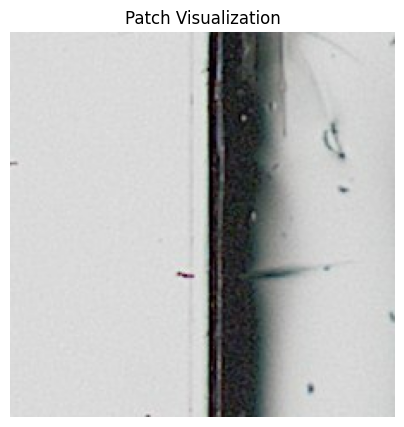

RGB Pixel Values:
[[[219 219 219]
  [220 220 220]
  [220 220 220]
  ...
  [213 215 214]
  [217 219 218]
  [214 216 215]]

 [[218 218 218]
  [219 219 219]
  [220 220 220]
  ...
  [214 216 215]
  [215 217 216]
  [210 212 211]]

 [[218 218 218]
  [219 219 219]
  [220 220 220]
  ...
  [213 215 214]
  [209 211 210]
  [199 201 200]]

 ...

 [[218 218 218]
  [219 219 219]
  [219 219 219]
  ...
  [205 207 206]
  [204 206 205]
  [203 205 204]]

 [[221 221 221]
  [220 220 220]
  [218 218 218]
  ...
  [207 209 208]
  [205 207 206]
  [203 205 204]]

 [[223 223 223]
  [221 221 221]
  [217 217 217]
  ...
  [209 211 210]
  [204 206 205]
  [200 202 201]]]

Patch Statistics:
Mean RGB: [184.63291215 185.47825654 185.16057478]
Min RGB: [0 0 0]
Max RGB: [242 240 235]
White Pixel Ratio: 0.71


In [64]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def analyze_patch_from_png(patch_path, show_pixel_values=True, show_statistics=True):
    """
    Analyze a patch stored as a PNG file.
    
    Args:
        patch_path (str): Path to the patch PNG image.
        show_pixel_values (bool): Whether to print pixel values.
        show_statistics (bool): Whether to compute and print patch statistics.
    """
    # Load the patch as a NumPy array
    patch = cv2.imread(patch_path)
    patch = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Display the patch
    plt.figure(figsize=(5, 5))
    plt.imshow(patch)
    plt.title("Patch Visualization")
    plt.axis("off")
    plt.show()

    # Print RGB pixel values (optional)
    if show_pixel_values:
        print("RGB Pixel Values:")
        print(patch)  # Will print a large array of pixel values

    # Compute patch statistics (optional)
    if show_statistics:
        num_pixels = patch.shape[0] * patch.shape[1]
        
        # Calculate mean, min, max for each channel
        mean_rgb = np.mean(patch, axis=(0, 1))
        min_rgb = np.min(patch, axis=(0, 1))
        max_rgb = np.max(patch, axis=(0, 1))
        
        # Ratio of white pixels
        summed_matrix = np.sum(patch, axis=-1)
        num_white_pixels = np.count_nonzero(summed_matrix > 620)  # White pixel condition
        ratio_white_pixels = num_white_pixels / num_pixels
        
        # Print statistics
        print("\nPatch Statistics:")
        print(f"Mean RGB: {mean_rgb}")
        print(f"Min RGB: {min_rgb}")
        print(f"Max RGB: {max_rgb}")
        print(f"White Pixel Ratio: {ratio_white_pixels:.2f}")


# # Example Usage
# # Assuming patches are saved as PNG files in a directory
# patch_dir = "C:\\Users\\Vivian\\Documents\\Selected_Patches"
# patch_files = [os.path.join(patch_dir, f) for f in os.listdir(patch_dir) if f.endswith(".png")]

# # Analyze the first patch
# if len(patch_files) > 0:
#     patch_path = patch_files[0]
#     print(f"Analyzing patch: {patch_path}")
#     analyze_patch_from_png(patch_path)
# else:
#     print("No patch files found for analysis.")

# one patch
patch_path = r"C:\Users\Vivian\Documents\Selected_Patches\patch_1019_x13952_y4992.png"
analyze_patch_from_png(patch_path)


range-based thresholding and white pixel thresholding - Amoon's code

Loaded WSI with shape: (7324, 15162, 3)
Extracted 1413 relevant patches.


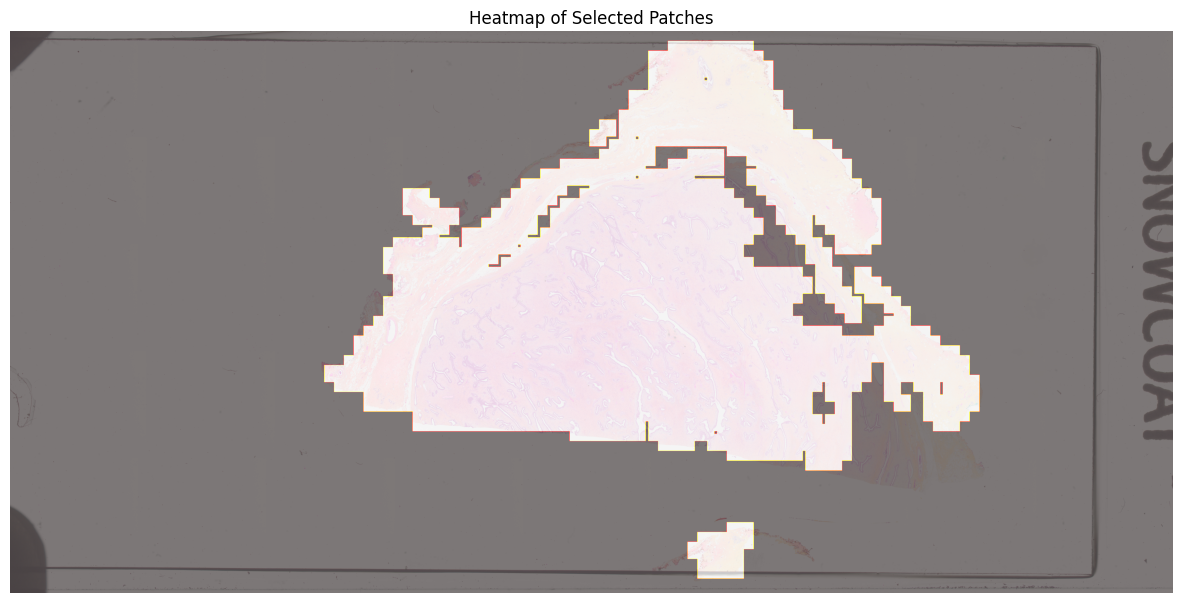

In [15]:
import os
import numpy as np
import openslide
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Parameters
PATCH_SIZE = 224  # Patch size (width, height)
STRIDE = 128  # Sliding window stride
WHITE_THRESHOLD = 0.8  # Max ratio of white pixels to exclude patch
BORDER_RGB_RANGE = [(0, 0, 0), (70, 60, 65)]  # RGB range for border-like regions
# BORDER_RGB_RANGE = [(0, 0, 0), (150, 150, 150)] 
BORDER_PIXEL_THRESHOLD = 0.01  # Max proportion of border-like pixels to exclude patch
# BORDER_PIXEL_THRESHOLD = 0.05

def compute_statistics2(image, threshold_rng):
    std = np.std(image, axis=-1)
    rng = np.max(image, axis=-1) - np.min(image, axis=-1)
    return np.sum(rng > threshold_rng)

    


def compute_statistics(image):
    """
    Compute the ratio of white pixels and border-like pixels in the patch.
    Args:
        image (numpy.array): Patch of the image (WxHxC).
    Returns:
        tuple: (white_pixel_ratio, border_pixel_ratio)
    """
    num_pixels = image.shape[0] * image.shape[1]
    
    # Calculate white pixel ratio
    summed_matrix = np.sum(image, axis=-1)  # Sum of RGB channels
    white_pixels = summed_matrix > 620  # Threshold for white pixels (RGB ~ [255, 255, 255])
    num_white_pixels = np.count_nonzero(white_pixels)
    ratio_white_pixels = num_white_pixels / num_pixels

    # Calculate border-like pixel ratio
    lower_range, upper_range = BORDER_RGB_RANGE
    border_pixels = np.all(
        (image >= lower_range) & (image <= upper_range),
        axis=-1
    )
    num_border_pixels = np.count_nonzero(border_pixels)
    ratio_border_pixels = num_border_pixels / num_pixels

    return ratio_white_pixels, ratio_border_pixels


def extract_patches(image, patch_size=224, stride=128, white_threshold=0.8, border_pixel_threshold=0.2):
    """
    Extract and filter patches based on white pixel ratio and border pixel ratio.
    Args:
        image (numpy.array): Input WSI image (RGB).
        patch_size (int): Size of each patch.
        stride (int): Stride for sliding window.
        white_threshold (float): Maximum allowed ratio of white pixels in a patch.
        border_pixel_threshold (float): Maximum allowed ratio of border-like pixels in a patch.
    Returns:
        list: Relevant patches with their coordinates.
    """
    patches = []
    h, w = image.shape[:2]

    for y in range(0, h - patch_size, stride):
        for x in range(0, w - patch_size, stride):
            patch = image[y:y + patch_size, x:x + patch_size, :]
            
            # First approach
            # # Compute patch statistics
            # white_ratio, border_ratio = compute_statistics(patch)
            
            # # Retain patch if both thresholds are satisfied
            # if white_ratio < white_threshold and border_ratio < border_pixel_threshold:
            #     patches.append({"patch": patch, "coordinates": (x, y)})

            # Second approach 
            temp = compute_statistics2(patch, 40) # determine if pixel is colour or not
            if temp.sum() > patch_size * patch_size * 0.4: # count number of colour pixels, see percentage of patch that is colour or white
                patches.append({"patch": patch, "coordinates": (x, y)})


    return patches


def visualize_patch_distribution(image, patches, patch_size=224):
    """
    Visualize the selected patches on the original image.
    Args:
        image (numpy.array): Input WSI image (RGB).
        patches (list): List of selected patches with their coordinates.
        patch_size (int): Size of each patch.
    """
    heatmap = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)

    for patch_data in patches:
        x, y = patch_data["coordinates"]
        heatmap[y:y + patch_size, x:x + patch_size] = 1.0

    plt.figure(figsize=(15, 15))
    plt.imshow(image, alpha=0.5)
    plt.imshow(heatmap, cmap="hot", alpha=0.5)
    plt.title("Heatmap of Selected Patches")
    plt.axis("off")
    plt.show()


def save_patches(patches, output_dir):
    """
    Save selected patches to disk.
    Args:
        patches (list): List of patches with their coordinates.
        output_dir (str): Directory to save patches.
    """
    os.makedirs(output_dir, exist_ok=True)
    for i, patch_data in enumerate(patches):
        patch = patch_data["patch"]
        x, y = patch_data["coordinates"]
        filename = os.path.join(output_dir, f"patch_{i}_x{x}_y{y}.png")
        cv2.imwrite(filename, cv2.cvtColor(patch, cv2.COLOR_RGB2BGR))


# Main Workflow
# slide_path = "C:\\Users\\Vivian\\Documents\\FA_57B\\FA57B-image.tif"
slide_path = "C:\\Users\\Vivian\\Documents\\PT_54_B1_image.tif"
output_dir = "C:\\Users\\Vivian\\Documents\\PT54_patches"

# Load WSI
slide = openslide.OpenSlide(slide_path)
image = np.array(slide.read_region((0, 0), 0, slide.level_dimensions[0]))[..., :3]
print(f"Loaded WSI with shape: {image.shape}")

# Extract relevant patches
patches = extract_patches(
    image,
    patch_size=PATCH_SIZE,
    stride=STRIDE,
    white_threshold=WHITE_THRESHOLD,
    border_pixel_threshold=BORDER_PIXEL_THRESHOLD
)
print(f"Extracted {len(patches)} relevant patches.")

# Visualize patch distribution
visualize_patch_distribution(image, patches, patch_size=PATCH_SIZE)

# Save patches
# save_patches(patches, output_dir)
# print(f"Patches saved to {output_dir}")


Modified visualization 

Loaded WSI with shape: (17097, 22330, 3)
Extracted 3671 relevant patches.


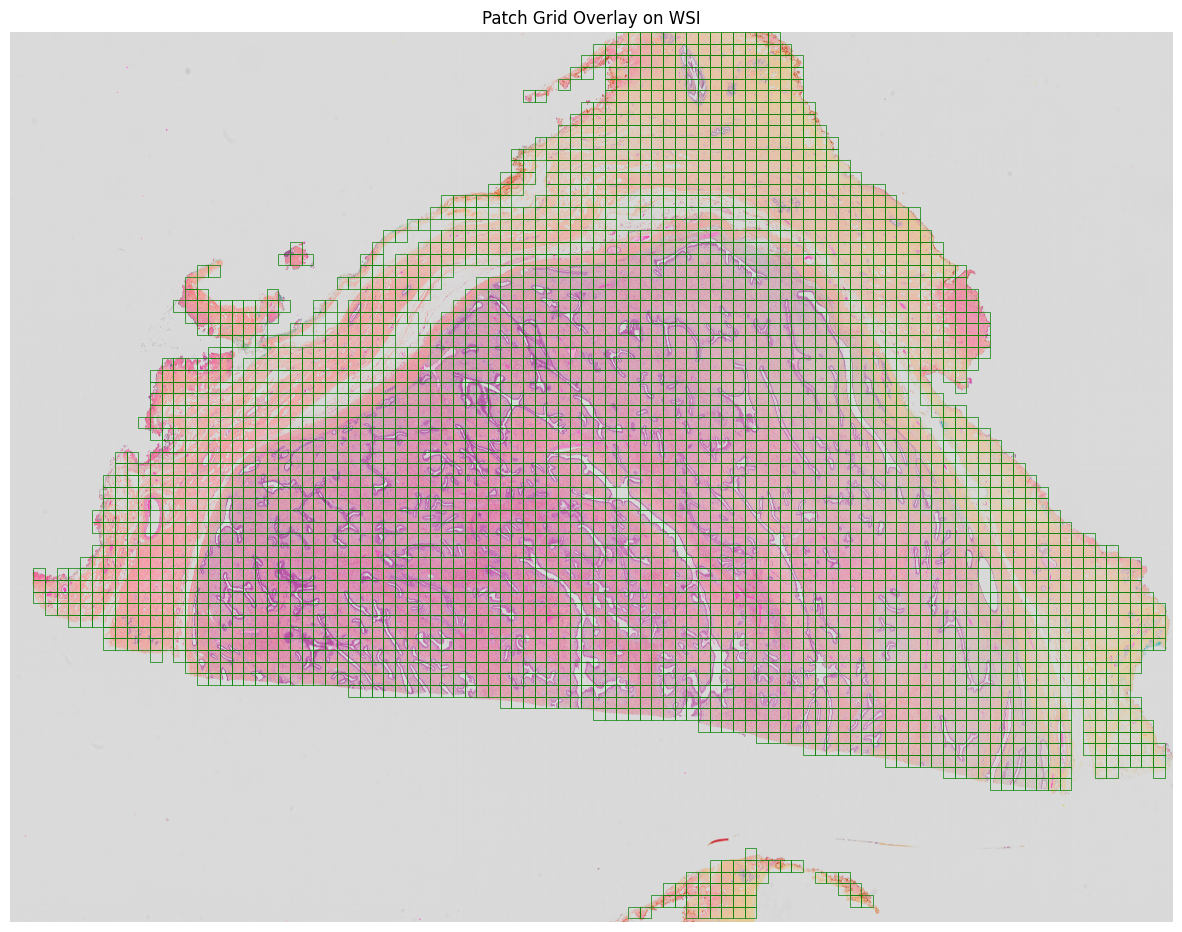

In [2]:
import os
import numpy as np
import openslide
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  


# Parameters
PATCH_SIZE = 224  # Patch size (width, height)
STRIDE = 224  # Sliding window stride

def compute_statistics2(image, threshold_rng):
    std = np.std(image, axis=-1)
    rng = np.max(image, axis=-1) - np.min(image, axis=-1)
    return np.sum(rng > threshold_rng)

    

def extract_patches(image, patch_size=224, stride=128):
    """
    Extract and filter patches based on white pixel ratio and border pixel ratio.
    Args:
        image (numpy.array): Input WSI image (RGB).
        patch_size (int): Size of each patch.
        stride (int): Stride for sliding window.
        white_threshold (float): Maximum allowed ratio of white pixels in a patch.
        border_pixel_threshold (float): Maximum allowed ratio of border-like pixels in a patch.
    Returns:
        list: Relevant patches with their coordinates.
    """
    patches = []
    h, w = image.shape[:2]

    for y in range(0, h - patch_size, stride):
        for x in range(0, w - patch_size, stride):
            patch = image[y:y + patch_size, x:x + patch_size, :]

            # Second approach 
            temp = compute_statistics2(patch, 10) # determine if pixel is colour or not
            if temp.sum() > patch_size * patch_size * 0.3: # count number of colour pixels, see percentage of patch that is colour or white
                patches.append({"patch": patch, "coordinates": (x, y)})

    return patches


def visualize_patch_distribution(image, patches, patch_size=224):
    """
    Overlay extracted patch locations as a grid on the original image.
    Args:
        image (numpy.array): Input WSI image (RGB).
        patches (list): List of selected patches with their coordinates.
        patch_size (int): Size of each patch.

    https://github.com/smujiang/WSITools/blob/master/docs/patch_extraction/patch_extraction.md 
    """
    fig, ax = plt.subplots(figsize=(15, 15))
    
    # Show the original image
    ax.imshow(image)

    # Overlay grid (patch outlines)
    for patch_data in patches:
        x, y = patch_data["coordinates"]
        rect = mpatches.Rectangle(  
            (x, y),  # Top-left corner
            patch_size,  # Width
            patch_size,  # Height
            linewidth=0.5,  # Thin border
            edgecolor="green",  # Grid color
            facecolor="none"  # Transparent fill
        )
        ax.add_patch(rect)

    plt.title("Patch Grid Overlay on WSI")
    plt.axis("off")  # Hide axes for a cleaner visualization
    plt.show()


def save_patches(patches, output_dir):
    """
    Save selected patches to disk.
    Args:
        patches (list): List of patches with their coordinates.
        output_dir (str): Directory to save patches.
    """
    os.makedirs(output_dir, exist_ok=True)
    for i, patch_data in enumerate(patches):
        patch = patch_data["patch"]
        x, y = patch_data["coordinates"]
        filename = os.path.join(output_dir, f"patch_{i}_x{x}_y{y}.png")
        cv2.imwrite(filename, cv2.cvtColor(patch, cv2.COLOR_RGB2BGR))


# Main Workflow
# slide_path = "C:\\Users\\Vivian\\Documents\\FA_57B\\FA57B-image.tif"
# slide_path = "C:\\Users\\Vivian\\Documents\\PT_54_B1_image.tif"
slide_path = "C:\\Users\\Vivian\\Documents\\PT_54_B1_image_6.tif"
output_dir = "C:\\Users\\Vivian\\Documents\\PT54_image6_level2_stride224"

# Load WSI
slide = openslide.OpenSlide(slide_path)

# Load a lower-resolution level (e.g., 1 instead of 0)
# level = min(1, len(slide.level_dimensions) - 1)  # Choose level 1 if available
level = 3
image = np.array(slide.read_region((0, 0), level, slide.level_dimensions[level]))[..., :3]

# image = np.array(slide.read_region((0, 0), 0, slide.level_dimensions[0]))[..., :3]
print(f"Loaded WSI with shape: {image.shape}")

# Extract relevant patches
patches = extract_patches(
    image,
    patch_size=PATCH_SIZE,
    stride=STRIDE
)
print(f"Extracted {len(patches)} relevant patches.")

# Visualize patch distribution
visualize_patch_distribution(image, patches, patch_size=PATCH_SIZE)

# Save patches
# save_patches(patches, output_dir)
# print(f"Patches saved to {output_dir}")


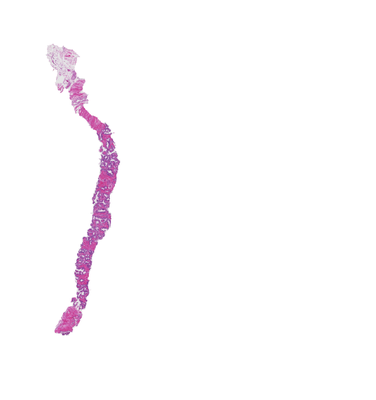

Slide dimensions (27648, 29440)
Level count 3
Level dimensions ((27648, 29440), (6912, 7360), (1728, 1840))
Level downsample (1.0, 4.0, 16.0)
Properties <_PropertyMap {'openslide.level-count': '3', 'openslide.level[0].downsample': '1', 'openslide.level[0].height': '29440', 'openslide.level[0].tile-height': '512', 'openslide.level[0].tile-width': '512', 'openslide.level[0].width': '27648', 'openslide.level[1].downsample': '4', 'openslide.level[1].height': '7360', 'openslide.level[1].tile-height': '512', 'openslide.level[1].tile-width': '512', 'openslide.level[1].width': '6912', 'openslide.level[2].downsample': '16', 'openslide.level[2].height': '1840', 'openslide.level[2].tile-height': '512', 'openslide.level[2].tile-width': '512', 'openslide.level[2].width': '1728', 'openslide.mpp-x': '0.45201826153776614', 'openslide.mpp-y': '0.45201826153776614', 'openslide.quickhash-1': 'e2cdaec3bc39bb0bf68b4b6d3c79480cac9525e1b7f202b4fd6d8e2f7333fe8b', 'openslide.vendor': 'generic-tiff', 'tiff.Reso

In [16]:
file_path = "C:\\Users\\Vivian\\Downloads\\panda_train\\0005f7aaab2800f6170c399693a96917.tiff"

# Create an OpenSlide object
slide = openslide.OpenSlide(file_path)

max_size=(600,400)
# generate small image thumbnail
display(slide.get_thumbnail(size=max_size))

# print out the properties of the slide

print("Slide dimensions", slide.dimensions)
print("Level count", slide.level_count)
print("Level dimensions", slide.level_dimensions)
print("Level downsample", slide.level_downsamples)
print("Properties", slide.properties)


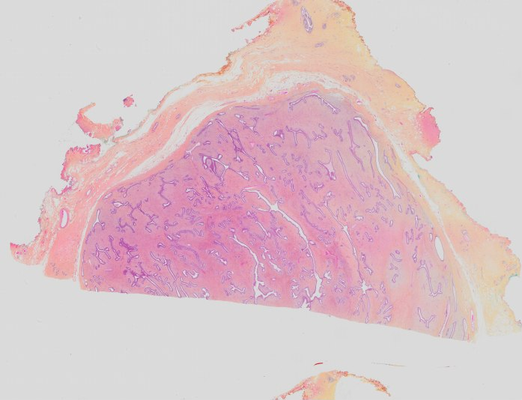

Slide dimensions (178640, 136782)
Level count 12
Level dimensions ((178640, 136782), (89320, 68391), (44660, 34195), (22330, 17097), (11165, 8548), (5582, 4274), (2791, 2137), (1395, 1068), (697, 534), (348, 267), (174, 133), (87, 66))
Level downsample (1.0, 2.0, 4.000029244041526, 8.000175469380594, 16.00081890500702, 32.003070988086414, 64.00614197617283, 128.06519068905803, 256.2222446117389, 512.812734082397, 1027.5513784461155, 2062.8939393939395)
Properties <_PropertyMap {'openslide.comment': 'ImageJ=\nhyperstack=true\nimages=3\nchannels=3\nslices=1\nframes=1', 'openslide.level-count': '12', 'openslide.level[0].downsample': '1', 'openslide.level[0].height': '136782', 'openslide.level[0].tile-height': '128', 'openslide.level[0].tile-width': '128', 'openslide.level[0].width': '178640', 'openslide.level[10].downsample': '1027.5513784461155', 'openslide.level[10].height': '133', 'openslide.level[10].tile-height': '128', 'openslide.level[10].tile-width': '128', 'openslide.level[10].wi

In [ ]:
file_path = "C:\\Users\\Vivian\\Documents\\PT_54_B1_image_6.tif"

# Create an OpenSlide object
slide = openslide.OpenSlide(file_path)

max_size=(600,400)
# generate small image thumbnail
display(slide.get_thumbnail(size=max_size))

# print out the properties of the slide

print("Slide dimensions", slide.dimensions)
print("Level count", slide.level_count)
print("Level dimensions", slide.level_dimensions)
print("Level downsample", slide.level_downsamples)
print("Properties", slide.properties)


